In [1]:
import csv
import sys
import json
import requests
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from dotenv import get_key, find_dotenv
from requests.auth import HTTPBasicAuth
import matplotlib as mplib
import matplotlib.pyplot as plt
import seaborn as sns
import calendar

%matplotlib inline

CENSUS_KEY = get_key(find_dotenv(), 'CENSUS_KEY')

SUCCESS_CODE = 200

# Part 1

### Data Retrieval
**Download and combine data from the open data portal for 2017 about the following 311 requests:**
* Graffiti Removal
* Vacant and Abandoned Buildings Reported
* Alley Lights Out

In [2]:
def convert_dates(date_series):
    '''
    Faster approach to datetime parsing for large datasets leveraging repated dates.

    Attribution: https://github.com/sanand0/benchmarks/commit/0baf65b290b10016e6c5118f6c4055b0c45be2b0
    '''
    dates = {date: pd.to_datetime(date) for date in date_series.unique()}
    return date_series.map(dates)

In [3]:
def compile_requests(params_file):
    '''
    Create dataframe for each of the given 311 services stored as keys in a given
    dictionary, each of which is a dictionary indicating a related CSV URL.

    Inputs:
        - params (list of dictionaries): service request type details including CSV 
            URL and column renaming details.
    Outputs:
        - intial_records (dataframe): pandas dataframe of historical 311 data
    '''
    service_types = ['abandoned_building', 'alley_light', 'graffiti']
    params = json.load(open(params_file))

    initial_records = []
    
    try:
        for service in service_types:
            # print("Starting: {}".format(service))
      
            r = requests.get(params[service]['url'])

            if r.status_code == SUCCESS_CODE:
                decoded_dl = r.content.decode('utf-8')
                req_reader = csv.reader(decoded_dl.splitlines(), delimiter = ',')
                read_info = list(req_reader)
                
                historicals_df = pd.DataFrame(read_info[1:], columns = read_info[0])
                historicals_df.rename(columns = params[service]['clean_cols'], inplace=True)
                
                ordered_df = historicals_df.reindex(columns = params[service]['order'])

                if service == 'abandoned_building':
                    ordered_df['street_address'] = ordered_df[['street_num', 'street_dir', 'street_name', 'street_suff']].astype(str).apply(lambda x: ' '.join(x), axis=1)

                else:
                    ordered_df['creation_date'] = convert_dates(ordered_df['creation_date'])
                    ordered_df['completion_date'] = convert_dates(ordered_df['completion_date'])

                    ordered_df['response_time'] = (ordered_df['completion_date'] - ordered_df['creation_date']).astype('timedelta64[D]')                
                 
                initial_records.append(ordered_df)

        full_df = pd.concat(initial_records)

        return full_df

    except Exception as e:
        print("Unexpected error: {}".format(e), file=sys.stderr)

In [4]:
saved_311 = compile_requests('params.json')
saved_311.head()

,boarded_indicator,community_area,completion_date,creation_date,entry_point,fire_indicator,hazardous_indicator,in_use,latitude,location,...,street_name,street_num,street_suff,surface_type,type_of_service_request,vacant_indicator,ward,x_coordinate,y_coordinate,zip
0,,,NaT,01/18/2008,,,,,,,...,ADDISON,7905,ST,NaN,Vacant/Abandoned Building,,,,,60613
1,Building is Open / Unsecure,68,NaT,04/03/2008,,,,,41.76819814695611,"(41.76819814695611, -87.65177097869127)",...,ABERDEEN,6929,ST,NaN,Vacant/Abandoned Building,Vacant,17,1170178.65847317,1858858.85797821,60621
2,Building is Open / Unsecure,44,NaT,04/05/2008,"GARAGE, VAGRANTS BROKE INTO GARAGE AND USE IT ...",,,true,41.745482414802325,"(41.745482414802325, -87.60628681474407)",...,EVANS,8216,AVE,NaN,Vacant/Abandoned Building,Vacant,6,1182656.66291261,1850683.0384131,60619
3,Building is Open / Unsecure,68,NaT,07/30/2008,REAR,,,,41.764673747551555,"(41.764673747551555, -87.63588403606937)",...,EGGLESTON,7136,AVE,NaN,Vacant/Abandoned Building,Vacant,6,1174523.01813413,1857609.33820458,60621
4,Building is Open / Unsecure,67,NaT,08/07/2008,FRONT AND REAR,,,,41.75956423181548,"(41.75956423181548, -87.65609637199394)",...,74TH,1265,ST,NaN,Vacant/Abandoned Building,Vacant,17,1169023.46491226,1855703.41030725,60636


In [5]:
def month_year_detail(df):
    df['creation_date'] = pd.to_datetime(df['creation_date'])
    df['month'] = df['creation_date'].dt.month
    df['year'] = df['creation_date'].dt.year
    
    # remove values for records that fall outside period described in metadata (post-2010)
    clean_df = df[df['year'] >= 2011]

    return clean_df

clean_311 = month_year_detail(saved_311)
clean_311.head()

,boarded_indicator,community_area,completion_date,creation_date,entry_point,fire_indicator,hazardous_indicator,in_use,latitude,location,...,street_suff,surface_type,type_of_service_request,vacant_indicator,ward,x_coordinate,y_coordinate,zip,month,year
6656,Open,30,NaT,2011-01-03,"FRONT,REAR",false,,false,41.85064087478168,"(41.85064087478168, -87.71374743655579)",...,AVE,NaN,Vacant/Abandoned Building,Vacant,22,1153054.96138095,1888772.61790888,60623,1,2011
6667,Open,29,NaT,2011-01-01,REAR,false,,false,41.861991117568905,"(41.861991117568905, -87.71285525975965)",...,AVE,NaN,Vacant/Abandoned Building,Vacant,24,1153268.14610007,1892910.36801408,60623,1,2011
6668,Open,25,NaT,2011-01-01,FRONT AND REAR,false,,true,41.89769807845251,"(41.89769807845251, -87.75812394284395)",...,AVE,NaN,Vacant/Abandoned Building,Vacant,37,1140849.70919731,1905836.05189713,60651,1,2011
6669,Open,20,NaT,2011-01-01,,false,,true,41.92080665863923,"(41.92080665863923, -87.72816564560988)",...,ST,NaN,Vacant/Abandoned Building,Vacant,31,1148946.422618,1914312.93159061,60639,1,2011
6670,Open,69,NaT,2011-01-01,,false,,true,41.76565998888494,"(41.76565998888494, -87.61284272023427)",...,AVE,NaN,Vacant/Abandoned Building,Vacant,6,1180806.00859116,1858020.5280188,60619,1,2011


In [6]:
clean_311.isnull().sum()

boarded_indicator          1169799
community_area                   0
completion_date              64129
creation_date                    0
entry_point                1169799
fire_indicator             1169799
hazardous_indicator        1169799
in_use                     1169799
latitude                         0
location                         0
longitude                        0
lot_location               1169799
police_district                  0
response_time                64129
service_request_number           0
ssa                         253462
status                       55457
street_address                   0
street_dir                 1169799
street_name                1169799
street_num                 1169799
street_suff                1169799
surface_type                253462
type_of_service_request          0
vacant_indicator           1169799
ward                             0
x_coordinate                971794
y_coordinate                     0
zip                 

### Summary Statistics

Generate summary statistics for these requests including but not limited to
number of requests of each type (and subtype within each of the types
above) over time, by neighborhood, response time by the city. Please use a
combination of tables and graphs to present these summary stats.

### Overall Number of Requests per Request Type

There have been exponentially more graffiti service requests than abandoned building or alley light out requests since 2011.

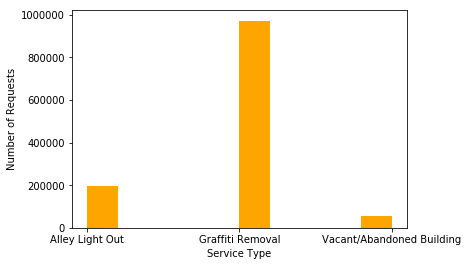

In [10]:
def visualize_top_level():
    plt.xlabel('Service Type')
    plt.ylabel('Number of Requests')
    plt.hist(clean_311['type_of_service_request'], color = 'orange')
    plt.show()

visualize_top_level()

### Number of Service Requests Throughout Year

There appears to be a higher number of requests submitted in December and January than any other month.

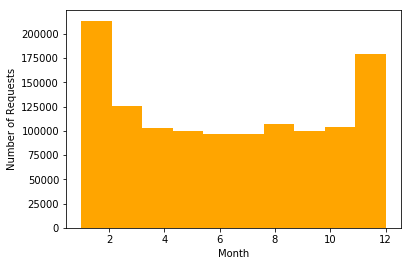

In [11]:
plt.xlabel('Month')
plt.ylabel('Number of Requests')
plt.hist(clean_311['month'], color = 'orange')
plt.show()

### Number Service Requests Year Over Year

The number of service requests year over year appears to have been declining slightly since 2013, after a large drop-off in 2011. Note that this is the year Rahm Emanuel became Mayor of Chicago.

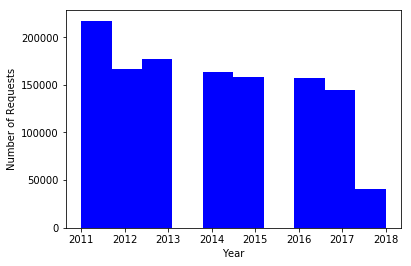

In [14]:
plt.xlabel('Year')
plt.ylabel('Number of Requests')
plt.hist(clean_311['year'], color = 'blue')
plt.show()

In [ ]:
date_counts = clean_311[clean_311.measurement.isin(['TMAX','TMIN','TAVG'])]
clean_311['datetime'] = pd.to_datetime(clean_311.creation_date, format='%Y%m%d')
chicago_temps.index = chicago_temps.datetime
chicago_temps.dtypes
chicago_temps.head()


In [ ]:
chicago_temps.groupby('measurement').value.plot(figsize=(15,5))

### Response Time to Service Requests

There is significantly more variation in response time for alley light out service requests than in graffiti removal requests, and average request resolution time is over 10 times longer for this type of request. 

Note that the city does not share completion dates for abandoned building requests, which could potentially be due to a variety of factors including but certainly not limited to exorbitantly long response times the city is not comfortable sharing, or simply the limited capacity of the city's data team.

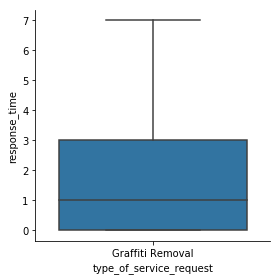

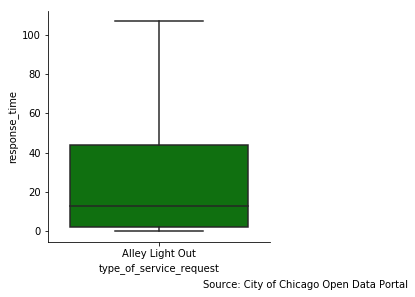

In [135]:
sns.factorplot(data=clean_311[clean_311['type_of_service_request'] == 'Graffiti Removal'], x='type_of_service_request', y='response_time', kind='box',showfliers=False)
sns.factorplot(data=clean_311[clean_311['type_of_service_request'] == 'Alley Light Out'], x='type_of_service_request', y='response_time', kind='box', color = 'green', showfliers=False)
plt.annotate('Source: City of Chicago Open Data Portal', xy=(0.7,-0.2), xycoords="axes fraction")
plt.tight_layout()

plt.show()

### Requests by Geography

In [64]:
def compile_geo_df(df):
    geo_ready = df[df['latitude'] != '']
    geo_grouping = geo_ready[['latitude', 'longitude', 'type_of_service_request', 'service_request_number']].groupby(['latitude', 'longitude', 'type_of_service_request']).count().unstack('type_of_service_request')
    geo_grouping = geo_grouping.fillna('0')
    geo_grouping_plot_ready = geo_grouping.reset_index()
    geo_grouping_plot_ready.columns = geo_grouping_plot_ready.columns.droplevel(0)
    geo_grouping_plot_ready = geo_grouping_plot_ready.reset_index().rename_axis(None, axis=1)
    geo_grouping_plot_ready.drop(['index'], axis = 1)
    geo_grouping_plot_ready.columns = ['index', 'longitude', 'latitude', 'Alley Light Out', 'Graffiti Removal','Vacant/Abandoned Building']
    
    return geo_grouping_plot_ready
    


In [65]:
plot_lat_lon = compile_geo_df(clean_311)

In [66]:
plot_lat_lon.head()

,index,longitude,latitude,Alley Light Out,Graffiti Removal,Vacant/Abandoned Building
0,0,41.64469535649149,-87.53980386178681,0,1,0
1,1,41.6447117352697,-87.5408663803913,0,1,0
2,2,41.64471259298648,-87.61146904483418,0,1,0
3,3,41.64473930758664,-87.5409026350459,0,1,0
4,4,41.64536949643727,-87.61722129247524,0,0,1


In [ ]:
fig, axes = plt.subplots(figsize=[16, 10], nrows= 3, ncols = 1, sharex='row', sharey='row', squeeze = True)

ax1, ax2, ax3 = axes

graffiti_scatter = ax1.scatter(plot_lat_lon['longitude'], plot_lat_lon['latitude'], c=plot_lat_lon['Graffiti Removal'], edgecolor='None', alpha=0.7, cmap=plt.get_cmap('icefire'))
ax1.set_xlim( [37,45])
ax1.set_ylim( [-90,-84])
ax1.set_title('Graffiti Requests')
ax1.set_ylabel('Latitude')

building_scatter = ax2.scatter(plot_lat_lon['longitude'], plot_lat_lon['latitude'], c=plot_lat_lon['Vacant/Abandoned Building'], edgecolor='None', alpha=0.7, cmap=plt.get_cmap('icefire'))
ax1.set_xlim( [37,45])
ax1.set_ylim( [-90,-84])
ax2.set_title('Abandoned Building Requests')

cholesterol_scatter = ax3.scatter(plot_lat_lon['longitude'], plot_lat_lon['latitude'],  c=plot_lat_lon['Alley Light Out'], edgecolor='None', alpha=0.7, cmap=plt.get_cmap('icefire'))
ax1.set_xlim( [37,45])
ax1.set_ylim( [-90,-84])
ax3.set_title('Alley Light Out Requests')
ax3.set_xlabel('Longitude')
ax3.set_ylabel('Latitude')
plt.annotate('Source: Source: City of Chicago Open Data Portal', xy=(0.2,-0.3), xycoords="axes fraction")


### Top 10 Zipcodes for Graffiti Requests

In [218]:
def zip_code_requests(df):
    clean_zip_311 = df[(clean_311.zip != 0) & (df.zip != '') & (df.zip != '0')]
    zip_requests = clean_zip_311.groupby(['zip','type_of_service_request'])['service_request_number'].count().unstack('type_of_service_request')
    zip_requests['% of Total Alley Light Out'] = (zip_requests['Alley Light Out'] / zip_requests['Alley Light Out'].sum() * 100)
    zip_requests['% of Graffiti Requests'] = (zip_requests['Graffiti Removal'] / zip_requests['Graffiti Removal'].sum() * 100)
    zip_requests['% of Vacant/Abandoned Building'] = (zip_requests['Vacant/Abandoned Building'] / zip_requests['Vacant/Abandoned Building'].sum() * 100)
    zip_requests = zip_requests.drop(['Alley Light Out', 'Graffiti Removal', 'Vacant/Abandoned Building'], axis = 1)
    zip_requests.fillna(value = 0, inplace = True)
    return zip_requests

zipcode_data = zip_code_requests(clean_311)

In [229]:
graffiti_zips = zipcode_data.sort_values(by = ['% of Graffiti Requests', '% of Vacant/Abandoned Building', '% of Total Alley Light Out'], ascending = False)[:10]
graffiti_zips

type_of_service_request,% of Total Alley Light Out,% of Graffiti Requests,% of Vacant/Abandoned Building
zip,,,
60632,3.617885,10.951126,1.917773
60608,2.304959,8.657708,1.513172
60647,2.405681,7.948642,1.380724
60618,2.812617,7.376961,1.126715
60623,2.887020,5.852650,3.973438
60629,6.179963,5.607644,3.467233
60609,2.517032,4.674273,5.138254
60639,2.749350,4.446877,1.544016
60622,1.541195,4.332562,0.669497


### Top 10 Zipcodes for Vacant Building Requests

In [231]:
vacant_bldg_zips = zipcode_data.sort_values(by = ['% of Vacant/Abandoned Building', '% of Total Alley Light Out', '% of Graffiti Requests'], ascending = False)[:10]
vacant_bldg_zips

type_of_service_request,% of Total Alley Light Out,% of Graffiti Requests,% of Vacant/Abandoned Building
zip,,,
60636,2.188547,0.396088,10.185790
60628,5.807444,0.320393,9.902751
60621,1.311407,0.199280,7.008854
60617,6.046342,2.162934,6.876406
60619,4.570439,0.164264,6.105305
60620,4.719751,0.257262,6.072647
60624,1.634324,0.336665,5.198128
60609,2.517032,4.674273,5.138254
60651,3.530323,0.928634,4.027868


### Top 10 Zipcodes for Alley Light Out Requests

In [232]:
alley_zips = zipcode_data.sort_values(by = ['% of Total Alley Light Out','% of Graffiti Requests', '% of Vacant/Abandoned Building'], ascending = False)[:10]
alley_zips

type_of_service_request,% of Total Alley Light Out,% of Graffiti Requests,% of Vacant/Abandoned Building
zip,,,
60629,6.179963,5.607644,3.467233
60617,6.046342,2.162934,6.876406
60628,5.807444,0.320393,9.902751
60638,4.873111,1.080746,0.576965
60620,4.719751,0.257262,6.072647
60619,4.570439,0.164264,6.105305
60632,3.617885,10.951126,1.917773
60634,3.559679,1.824827,0.841861
60651,3.530323,0.928634,4.027868


### Double-Whammy Zipcodes
#### Zipcodes in top 10 for multiple service request types

* Zipcodes near Midway airport (60632, 60629) have a higher percentage of both vacant/ abandonded building service requests. 
* Austin/ Humbolt Park border (60651), Calumet Heights/ South Derring/ East Side (60617), Auburn Gresham/ Chathm border (60620, 60619), and the Pullman/ Roseland area (60628) have had higher percentages of graffiti and alley light our service requests since 2011. 
* North and South Lawndale/ Little Village (60623), and Back of the Yards/ Fuller Park (60609) have both higher rates of vacant building requests and higher rates of graffiti requests.

In [254]:
alley_set = set(alley_zips.index)
bldg_set = set(graffiti_zips.index)
graffiti_set = set(vacant_bldg_zips.index)

print("""Zip codes high in both vacant building and alley light out requests: 
{}""".format(alley_set.intersection(bldg_set)))
print()
print("""Zip codes high in both graffiti and alley light out requests: 
{}""".format(alley_set.intersection(graffiti_set)))
print()
print("""Zip codes high in both vacant building and graffiti out requests: 
{}""".format(bldg_set.intersection(graffiti_set)))

Zip codes high in both vacant building and alley light out requests: 
{'60632', '60629'}

Zip codes high in both graffiti and alley light out requests: 
{'60651', '60617', '60620', '60619', '60628'}

Zip codes high in both vacant building and graffiti out requests: 
{'60623', '60609'}


### Service Request Subtype Breakdown

For abandoned buildings, 85% of reported buildings were open and vulnerable to squatters. 46% of  abandoned buildings were reported in-use by people experiencing homelessness, gangs, or children.

Just under 60% of 971,794 graffiti removal requests were for graffiti on brick or painted metal. Less than one percent of graffiti requests were for graffiti removal from limestone, marble/ granite, asphalt, stuccko, and trees. This begs the question of whether Chicagoans refrained from tagging these harder-to-clean surfaces, or if those who noticed intances of graffiti on these materials were just too skeptical of the city's abiilty to remove it to report them.  

### Total Number of Requests by Service Type

In [170]:
clean_311['type_of_service_request'].value_counts()

Graffiti Removal             971794
Alley Light Out              198005
Vacant/Abandoned Building     55457
Name: type_of_service_request, dtype: int64

### Number of Requests by Subtype

In [165]:
def view_subtypes(df):
    subtypes = {'Graffiti Removal': ['surface_type'], 'Alley Light Out': [], 'Vacant/Abandoned Building': ['boarded_indicator', 'fire_indicator', 'hazardous_indicator',
                'in_use', 'vacant_indicator']}

    
    service_types = df['type_of_service_request'].unique()
   
    top_level_counts = df['type_of_service_request'].value_counts()

    count_dict = {}
    for service_type, count in top_level_counts.items(): 
        count_dict[service_type] = count
    
    for service in service_types:
        print("Total number of {} requests: {}".format(service, count_dict[service]))
        print()
        service_reqs = df[saved_311['type_of_service_request'] == service]
        service_subs = subtypes[service]
        if len(service_subs) > 0:
            stats = pd.DataFrame()
            cols = [stats]
        else:
            cols = None
        for subtype in service_subs:
            sub_counts = service_reqs[subtype].value_counts() 
            cols.append(sub_counts)
        if cols:
            stats_frame = pd.concat(cols, axis = 1)
            stats_frame.fillna(value = 0, inplace = True)
            print(stats_frame)
            
           

In [166]:
stats_df = view_subtypes(saved_311) 
stats_df

Total number of Vacant/Abandoned Building requests: 62125

                             boarded_indicator  fire_indicator  \
                                        7875.0          8727.0   
Boarded                                 6877.0             0.0   
Building is Boarded Up                    33.0             0.0   
Building is Open / Unsecure              258.0             0.0   
Occupied                                   0.0             0.0   
Open                                   47082.0             0.0   
Unknown                                    0.0             0.0   
Vacant                                     0.0             0.0   
false                                      0.0         49115.0   
true                                       0.0          4283.0   

                             hazardous_indicator   in_use  vacant_indicator  
                                         62125.0   8164.0            7867.0  
Boarded                                      0.0      0.0 

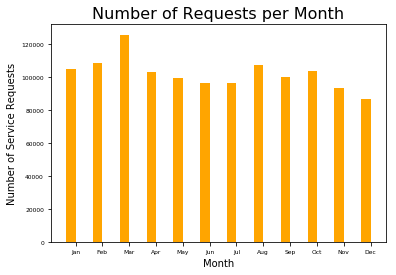

In [257]:
service = clean_311[] 
service.index = service['creation_date']
y_val = tuple(service.groupby(by=[service.index.month]).count()['creation_date'])
x_val = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

N = 12
counts = y_val


fig, axes = plt.subplots(figsize=[16, 10], nrows= 3, ncols = 1, sharex='row', sharey='row', squeeze = True)

ax1, ax2, ax3 = axes

month_freq_bar = ax.bar(ind, counts, width, color='orange')

# add some text for labels, title and axes ticks
ax1.set_title('Graffiti Requests per Month', fontsize = 16)
ax2.set_title('Vacant Building Requests per Month', fontsize = 16)
ax3.set_title('Alley Light Out Requests per Month', fontsize = 16)
ax.set_ylabel('Number of Service Requests', fontsize=10)
ax.set_xlabel('Month', fontsize = 10)
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(x_val)

plt.tick_params(labelsize=6)

plt.show()

In [8]:
small = clean_311[:20]

In [32]:
acs_variables = {
    "NAME": "block_name",
    "B01003_001E": "block_population",
    "B15003_022E": "bachelors_degree",
    "B03001_003E": "hispan_pop",
    "B02001_002E": "white_pop",
    "B17001_002E": "under_poverty_line",
    "B02001_003E": "black_population",
    "C24010_059E": "female_law_enforcement",
    "C24010_023E": "male_law_enforcement",
    "B08136_011E": "walk_commute_minutes",
    "B19013_001E": "median_income",
    "tract": "census_tract",
    "block group": "block_group"
}

# 17 031 681100 5 009

In [80]:
small.head()

,boarded_indicator,community_area,completion_date,creation_date,entry_point,fire_indicator,hazardous_indicator,in_use,latitude,location,...,hispan_pop,white_pop,under_poverty_line,black_population,female_law_enforcement,male_law_enforcement,walk_commute_minutes,median_income,census_tract,block_group
6656,Open,30,NaT,2011-01-03,"FRONT,REAR",false,,false,41.85064087478168,"(41.85064087478168, -87.71374743655579)",...,None,None,None,None,None,None,None,None,None,None
6667,Open,29,NaT,2011-01-01,REAR,false,,false,41.861991117568905,"(41.861991117568905, -87.71285525975965)",...,None,None,None,None,None,None,None,None,None,None
6668,Open,25,NaT,2011-01-01,FRONT AND REAR,false,,true,41.89769807845251,"(41.89769807845251, -87.75812394284395)",...,None,None,None,None,None,None,None,None,None,None
6669,Open,20,NaT,2011-01-01,,false,,true,41.92080665863923,"(41.92080665863923, -87.72816564560988)",...,None,None,None,None,None,None,None,None,None,None
6670,Open,69,NaT,2011-01-01,,false,,true,41.76565998888494,"(41.76565998888494, -87.61284272023427)",...,None,None,None,None,None,None,None,None,None,None


In [10]:
def add_acs_variables(df):
    for var, col in acs_variables.items():
        sLength = len(df['latitude'])
        make_series = [None] * sLength
        df[col] = pd.Series(make_series, index=df.index)

In [11]:
add_acs_variables(small)
small.head()

/Applications/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


,boarded_indicator,community_area,completion_date,creation_date,entry_point,fire_indicator,hazardous_indicator,in_use,latitude,location,...,hispan_pop,white_pop,under_poverty_line,black_population,female_law_enforcement,male_law_enforcement,walk_commute_minutes,median_income,census_tract,block_group
6656,Open,30,NaT,2011-01-03,"FRONT,REAR",false,,false,41.85064087478168,"(41.85064087478168, -87.71374743655579)",...,None,None,None,None,None,None,None,None,None,None
6667,Open,29,NaT,2011-01-01,REAR,false,,false,41.861991117568905,"(41.861991117568905, -87.71285525975965)",...,None,None,None,None,None,None,None,None,None,None
6668,Open,25,NaT,2011-01-01,FRONT AND REAR,false,,true,41.89769807845251,"(41.89769807845251, -87.75812394284395)",...,None,None,None,None,None,None,None,None,None,None
6669,Open,20,NaT,2011-01-01,,false,,true,41.92080665863923,"(41.92080665863923, -87.72816564560988)",...,None,None,None,None,None,None,None,None,None,None
6670,Open,69,NaT,2011-01-01,,false,,true,41.76565998888494,"(41.76565998888494, -87.61284272023427)",...,None,None,None,None,None,None,None,None,None,None


In [15]:
def get_fips(lat, lon):
    response = requests.get("https://geo.fcc.gov/api/census/block/find?latitude=41.76819814695611&longitude=-87.65177097869127&showall=false&format=json")
    result = response.json()
    block_group = result['Block']['FIPS'][11]
    tract = result['Block']['FIPS'][5:11]
    return (block_group, tract)

def get_acs_data(lat, lon):
    group, tract = get_fips(lat, lon)
    response = requests.get("https://api.census.gov/data/2015/acs5?get=NAME,B01003_001E,B15003_022E,B03001_003E,B02001_002E,B17001_002E,B02001_003E,C24010_059E,C24010_023E,B08136_011E,B19013_001E&for=block%20group:{}&in=state:17%20county:031%20tract:{}&key={}".format(group, tract, CENSUS_KEY))
    return response.json()

In [73]:
def retrive_responses(lat, lon, vars_mapping):
    acs_response = get_acs_data(lat, lon)
    vars_req = acs_response[0]
    
    # make sure None values are included
    vars_response = [var if var is not None else 0 for var in acs_response[1]]
    assert len(vars_req) == len(vars_response)
    
    vars_dict = {}

    for ind, req in enumerate(vars_req):
        if req in ('NAME', 'county', 'state'):
            continue
        focus_var = vars_mapping[req] 
        vars_dict[focus_var] = vars_response[ind]

    return vars_dict

In [74]:
acs_response_dict = retrive_responses(41.76819814695611, -87.65177097869127, acs_variables)

In [75]:
acs_response_dict

{'bachelors_degree': '0',
 'black_population': '513',
 'block_group': '5',
 'block_population': '526',
 'census_tract': '681100',
 'female_law_enforcement': '0',
 'hispan_pop': 0,
 'male_law_enforcement': '0',
 'median_income': '14792',
 'under_poverty_line': 0,
 'walk_commute_minutes': 0,
 'white_pop': '13'}

In [60]:
for var, val in acs_response_dict.items():
    print(var)
    print(val)
    small.loc[small[(small.latitude.astype('float') == 41.76819814695611) & (small.longitude.astype('float') == -87.65177097869127)], var] =  val
    
    dates = {loc: pd.to_datetime(date) for loc in df['location'].unique()}
    return date_series.map(dates)
    
    
    

block_population
526


ValueError: cannot copy sequence with size 44 to array axis with dimension 0

In [76]:
unique_lat_lon = plot_lat_lon[['latitude', 'longitude']]
unique_lat_lon.head()

unique_locs = [tuple(loc) for loc in unique_lat_lon.to_records(index=False)]

In [ ]:
for lat, lon in unique_locs:
    df['d'] = df.apply(lambda x: some_func(a = x['a'], b = x['b'], c = x['c']), axis=1)retrive_responses(lat, lon, )

In [ ]:
# def convert_dates(date_series):
    # dates = {date: pd.to_datetime(date) for date in date_series.unique()}
    # return date_series.map(dates)

In [ ]:
# def populate_acs_cols(df, grouped_loc_df)
    acs_vals = {val: pd.to_datetime(date) for loc in df['location'].unique()}
    return date_series.map(dates)
    # unique_lat_lon = grouped_loc_df[['latitude', 'longitude']]
    for var, col in acs_variables.items():
        df.loc[:,col] = df.apply(lambda x: some_func(a = x['latitude'], b = x['longitude']), axis=1)
    



In [84]:
for ind, df_row in small.iterrows():
    acs_dict = retrive_responses(df_row['latitude'], df_row['longitude'], acs_variables)
    for var, val in acs_response_dict.items():
        print(ind)
        print(var)
        print(val)
        print(small.iloc[ind, var])
        small.iloc[1, var] =  val

6656
block_population
526


IndexError: single positional indexer is out-of-bounds

In [ ]:
# populate_acs_cols(small, plot_lat_lon)